# **Introduction to surrogate Modelling**

Pierre Kerfriden, Mines ParisTech / Cardiff University

## **Content:**

- Exercise 1. Frequentist model selection
- Exercise 2. Bayesian model selection
- Exercise 3. Nonparametric bayesian modelling
- (Exercise 4. Bayesian optimisation)

[Link to lecture slides](http://1drv.ms/b/s!AjM6vw3llOZ-iLQsUnA1fDuXluTVQg)

[Supplementary material](https://1drv.ms/b/s!AjM6vw3llOZ-i5I0v-aZCC9_Rjfo_w?e=y6TSoi)

---


**Exercise 1. Frequentist model selection**

1. Suggest an algorithm to select the polynomial order optimally. The number of model evaluations is fixed for now (*e.g.* 10 points) 
2. Suggest an algorithm to select number of model evaluations optimally when the polynomial order is fixed
3. Suggest an algorithm to select the polynomial order AND number of model evaluations optimally
4. Suggest an algorithm to select the polynomial order, number of model evaluations and ridge regularisation parameter optimally

Note: np.random.seed(x) allows you to fix the seed of the random generator. If unchanged, the code will generate the same pseudo-random number every time it is ran. Change x if you want to generate new random evaluation points.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import linear_model #conda install -c anaconda scikit-learn


# https://en.wikipedia.org/wiki/Legendre_polynomials
# Legendre polynomial 
def PLegendre(n, x):   
    if(n == 0):
        return 0.*x + 1. # P0 = 1 
    elif(n == 1): 
        return x # P1 = x 
    else: 
        return (((2 * n)-1)*x * PLegendre(n-1, x)-(n-1)*PLegendre(n-2, x))/float(n) 

class SimpleModel1D:
    
    def eval(self,x) :
        f = np.sin(3.0*x-2.25) + abs(x) + x
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,c='black',)

In [ ]:
class LegendreMM1D:
    
    def __init__(self):
         
        self.FullModel = None
        self.order = 2
        self.NbQPs = 0
        self.TypeQuadrature = 'MC'
        self.QPWeights = None
        self.QPs = None
        self.Vals = None
        self.RidgeCoeff = 1.e-8
    
    def BuildQuadrature(self):
        
        if self.TypeQuadrature == 'MC':
            self.QPs = 2.0 * np.random.rand(self.NbQPs,1) - 1.0
            self.QPWeights = 1.0/self.NbQPs * np.ones((self.NbQPs,1))
        elif self.TypeQuadrature== 'clenshaw_curtis':
            if self.NbQPs == 0:
                self.NbQPs = self.order+1
            self.QPs, self.QPWeights = clenshaw_curtis_compute( self.NbQPs )
            # https://people.sc.fsu.edu/~jburkardt/py_src/quadrule/quadrule.html
            print('self.QPs : ', self.QPs)
            print('self.QPWeights : ' , self.QPWeights)
        elif self.TypeQuadrature == 'Uniform':
            self.QPs = np.linspace(-1,1,self.NbQPs)
            self.QPWeights = 1.0/self.NbQPs * np.ones((self.NbQPs,1))
        else:
            print('not coded')
    
    def Fit(self):         
        self.Vals = np.zeros((len(self.QPs),1))
        for i in range(len(self.QPs)):
            self.Vals[i] = self.FullModel.eval(self.QPs[i])

        A = np.zeros((len(self.QPs),self.order+1))
        for i in range(len(self.QPs)):    
            for j in range(self.order+1):
                A[i,j] = PLegendre(j,self.QPs[i])
                #print('PLegendre(j,self.QPs[i])',PLegendre(j,self.QPs[i]))
        b = np.zeros((len(self.QPs),1)) 
        b = np.matmul(np.transpose(A),self.Vals)
        A = np.matmul(np.transpose(A),A)

        A = A + self.RidgeCoeff * np.eye(self.order+1) # L2 regularisation
        self.Weights = np.linalg.solve(A, b)
        #print('np.linalg.cond(A) :',np.linalg.cond(A))
    
    def eval(self,x) :
        f = 0
        for i in range(self.order+1):
            f = f + self.Weights[i] * PLegendre(i,x) 
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,'b')
        plt.scatter(self.QPs,self.Vals,marker='o', c='black')

 ----------------------------------
 ---------- Exercise CV -----------
 ----------------------------------
 -------------------------------------------
 ---------- Fit regression model -----------
 -------------------------------------------
Number model evaluation 10
Polynomial Order 5
MSE 0.0011245510215026453
R2: 0.9987262145565903


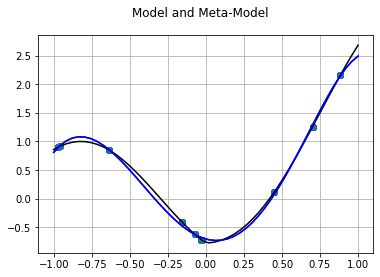

 ---------------------------------------
 ---------- Cross validation -----------
 ---------------------------------------
MSE CV : 0.17238449910376008
R2 CV: 0.8047390812606888


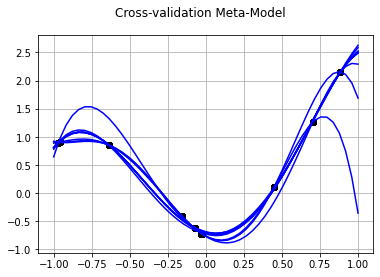

In [ ]:
def MonteCarloMetaModel():

    print(' ----------------------------------')
    print(' ---------- Exercise CV -----------')
    print(' ----------------------------------')

    NbEvaluationsPoints = 10
    Order = 5

    L2RegularisationCoeff = 1.0e-8

    np.random.seed(11)

    print(' -------------------------------------------')
    print(' ---------- Fit regression model -----------')
    print(' -------------------------------------------')

    plt.figure()

    M = SimpleModel1D()
    MM = LegendreMM1D() 
    MM.FullModel = M
    MM.order = Order 
    MM.TypeQuadrature = 'MC'
    MM.NbQPs = NbEvaluationsPoints
    MM.RidgeCoeff = L2RegularisationCoeff 

    MM.BuildQuadrature()
    MM.Fit()
    MM.plot([-1,1],50)  
    M.plot([-1,1],50)
    plt.suptitle('Model and Meta-Model', fontsize=12)
    MM.plot([-1,1],50)
    plt.scatter(MM.QPs,M.eval(MM.QPs)) 

    Error = np.zeros((len(MM.QPs),1))
    MSE = 1./len(MM.Vals) * np.linalg.norm( MM.Vals - MM.eval(MM.QPs) )**2
    TotalVariance = 1./len(MM.Vals) * np.linalg.norm(MM.Vals - np.mean(MM.Vals))**2
    print('Number model evaluation', len(MM.QPs))
    print('Polynomial Order', MM.order )
    print('MSE', MSE )
    print('R2:', 1-MSE/TotalVariance )

    plt.grid()
    plt.show() 

    print(' ---------------------------------------')
    print(' ---------- Cross validation -----------')
    print(' ---------------------------------------')

    CV = 1
    if (CV==1): # CV
        plt.figure()
        MMB = LegendreMM1D() 
        MMB.FullModel = M
        MMB.order = MM.order 
        MMB.TypeQuadrature = 'MC'
        MMB.QPWeights = np.copy(MM.QPWeights )
        MMB.QPs = np.copy(MM.QPs)
        MMB.RidgeCoeff = MM.RidgeCoeff  
        
        Error = np.zeros((len(MM.QPs),1))
        Variance = np.zeros((len(MM.QPs),1))
        for i in range(len(MM.QPs)):
            
            Perm = range(len(MM.QPs))
            index = [i]
            Perm = np.delete(Perm,index)
            MMB.QPs = MM.QPs[Perm]
            
            MMB.Fit()
            MMB.plot([-1,1],50)   
            
            Error[i] = ( MM.Vals[i] - MMB.eval(MM.QPs[i]) )**2 
        
        MSECV = np.mean( Error )
        print( 'MSE CV :', MSECV  )
        print( 'R2 CV:', 1-MSECV/TotalVariance )
        
        #MM.plot([-1,1],50)
        plt.suptitle('Cross-validation Meta-Model', fontsize=12)
        plt.grid()
        plt.show() 

MonteCarloMetaModel()



---


**Exercise 2. Bayesian model selection** 

- Select the polynomial order for N=30 model evaluation (random sequence)
- Suggest an algorithm for choosing the polynomial order (which may differ for the two input dimensions) and the number of model evaluations

Note: you may also switch to a compressive sensing model (TypeRegularisation = 1) and investigate the effect of the corresponding regularisation coefficient (RegulCoeff)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model   

# https://en.wikipedia.org/wiki/Legendre_polynomials
# Legendre polynomial 
def PLegendre(n, x):   
    if(n == 0):
        return 0.*x + 1. # P0 = 1 
    elif(n == 1): 
        return x # P1 = x 
    else: 
        return (((2 * n)-1)*x * PLegendre(n-1, x)-(n-1)*PLegendre(n-2, x))/float(n) 


def PLegendre2D(n, x):  
    return PLegendre(n[0], x[0]) * PLegendre(n[1], x[1])     

def PLegendre2DStacked(n,order,x):
    i2 = np.floor(float(n)/float(order+1))
    i1 = n - i2 * (order+1)
    #print('n',n,'i1 ',i1,' i2 ', i2)
    return PLegendre2D([i1,i2], x)

class SimpleModel2D: 

    def eval(self,x,y) :
        a = 2. # https://en.wikipedia.org/wiki/Rosenbrock_function
        b = 1.
        #f = np.heaviside(x,0.) * (y-x**2)**2
        f = x * (y-x**2)**2
        #f = a * (1-x**2) + b * (y-x**2)**2
        return f
    
    def plot(self,xLim,yLim,NPoint):
        fig = plt.figure()
        xPlot = np.linspace(xLim[0],xLim[1], NPoint[0])
        yPlot = np.linspace(yLim[0],yLim[1], NPoint[1])
        X, Y = np.meshgrid(xPlot, yPlot)
        Z = self.eval(X,Y)
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, Z)
        plt.xlabel('x')
        plt.ylabel('y')

In [ ]:
class LegendreMM2D:
    
    def __init__(self):
         
        self.FullModel = None
        self.order = None
        self.QPWeights = None
        self.QPWeightsVar = None
        self.QPs = None
        self.NbQPs = 0
        self.TypeQuadrature = 'MC'
        self.Vals = None
        self.TypeRegularisation = 1
        self.RegulCoeff = 1.e-8
    
    def BuildQuadrature(self):
        
        if self.TypeQuadrature == 'MC':
            self.QPs = 2.0 * np.random.rand(self.NbQPs,2) - 1.0
            self.QPWeights = 1.0/self.NbQPs * np.ones((self.NbQPs,1))
        else:
            print('not coded')
    
    def Fit(self):
        self.Vals = np.zeros((len(self.QPs),1))
        for i in range(len(self.QPs)):
            self.Vals[i] = self.FullModel.eval(self.QPs[i,0],self.QPs[i,1])
        
        if self.TypeRegularisation==1:
        # polynomial chaos
        #     A = np.zeros( ((self.order+1)**2,(self.order+1)**2) )
        #     b = np.zeros(((self.order+1)**2,1))
 
        #     for i in range((self.order+1)**2):
        #         b[i] = 0
        #         for k in range(len(self.QPs)):
        #             b[i] = b[i] + self.QPWeights[k] * self.Vals[k] * PLegendre2DStacked(i,self.order,self.QPs[k])
             
        #         for j in range((self.order+1)**2):
        #             A[i,j] = 0
        #             for k in range(len(self.QPs)):
        #                 #print(PLeg(self.order, self.QPs[k]) )
        #                 A[i,j] = A[i,j] + self.QPWeights[k] * PLegendre2DStacked(i,self.order,self.QPs[k]) * PLegendre2DStacked(j,self.order,self.QPs[k])
            A = np.zeros( (len(self.QPs),(self.order+1)**2) )
            for i in range(len(self.QPs)):    
                for j in range((self.order+1)**2):
                    A[i,j] = PLegendre2DStacked(j,self.order,self.QPs[i])
            b = np.zeros((len(self.QPs),1)) 
            b = np.matmul(np.transpose(A),self.Vals)
            A = np.matmul(np.transpose(A),A)

            # L2 regularisation
            A = A + self.RegulCoeff * np.eye((self.order+1)**2)
            self.Weights = np.linalg.solve(A, b)
            print('np.linalg.cond(A)', np.linalg.cond(A))

            print('Regression weights :', self.Weights.T)
        
        elif self.TypeRegularisation==2 or self.TypeRegularisation==3:  
        # L1 regularisation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
            
            A = np.zeros( ( len(self.QPs) , (self.order+1)**2-1 ) )
            for i in range(len(self.QPs)):
                for j in range(1,(self.order+1)**2):
                    A[i,j-1] = PLegendre2DStacked(j,self.order,self.QPs[i])
            # difference in numbering because line of 1s (intercept in A) not included in sklearn
            
            if self.TypeRegularisation==2:
                # https://xavierbourretsicotte.github.io/lasso_derivation.html
                clf = linear_model.Lasso(alpha=self.RegulCoeff)
            elif self.TypeRegularisation==3:
                clf = linear_model.BayesianRidge(compute_score=True)
            #clf = linear_model.Ridge(alpha=.5)
            
            clf.fit(A,self.Vals.ravel())
            self.Weights = np.append(clf.intercept_,clf.coef_)
            print('Regression weights :', self.Weights)
        
            if self.TypeRegularisation==3:
                self.WeightsVariance = clf.sigma_
                self.PrecisionNoise = clf.alpha_
                self.PrecisionWeights = clf.lambda_
                #print('self.PrecisionNoise',self.PrecisionNoise)
                #print('self.PrecisionWeights',self.PrecisionWeights)
                #print(clf.sigma_)
                #print(clf.sigma_.shape)
                #print(clf.coef_.shape)
                print('log Marginal Likelihood:',clf.scores_)

    def eval(self,x,y) :
        f = 0
        for i in range((self.order+1)**2):
            f = f + self.Weights[i] * PLegendre2DStacked(i,self.order,[x,y]) 
        f = f
        return f
    
    def plot(self,xLim,yLim,NPoint):
        fig = plt.figure()
        xPlot = np.linspace(xLim[0],xLim[1], NPoint[0])
        yPlot = np.linspace(yLim[0],yLim[1], NPoint[1])
        X, Y = np.meshgrid(xPlot, yPlot)
        Z = self.eval(X,Y)
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, Z)

        if (1 and self.TypeRegularisation==3):
            ZPlus = np.copy(Z)
            ZMinus = np.copy(Z)
            for i in range(len(X)):
                for j in range(len(Y)):

                    PhiX = np.zeros(((self.order+1)**2-1,1))
                    for k in range( 1,(self.order+1)**2 ):
                        PhiX[k-1] = PLegendre2DStacked(k,self.order,[xPlot[i],xPlot[j]])

                    SigmaTmp = np.matmul(self.WeightsVariance,PhiX)
                    SigmaTmp = np.matmul(np.transpose(PhiX),SigmaTmp)
                
                    ZMinus[i,j] = Z[i,j] - 1.96 * np.sqrt( 1.0 / self.PrecisionNoise + SigmaTmp )
                    ZPlus[i,j] = Z[i,j] + 1.96 * np.sqrt( 1.0 / self.PrecisionNoise + SigmaTmp )
        
            #print('Variance Noise',1.0 / self.PrecisionNoise)
            #print('Variance Weights',SigmaTmp)

            ax.plot_surface(X, Y, ZMinus, color = 'blue')
            ax.plot_surface(X, Y, ZPlus, color = 'red')

        if (1 and self.TypeRegularisation==3):
            WeightsOld = self.Weights
            for i in range(3):
                mean = WeightsOld[range(1,len(WeightsOld))]
                Tmp = np.random.multivariate_normal(mean, self.WeightsVariance, 1).T
                self.Weights = np.append(WeightsOld[0],Tmp)
                Z = self.eval(X,Y) 
                #for k in range(len(X)):
                #    for j in range(len(Y)):
                #        Z[k,j] = Z[k,j] + np.random.normal(0. , np.sqrt(1.0/ self.PrecisionNoise), 1)
                #RN = np.random.multivariate_normal( [0] , [[1.0/ self.PrecisionNoise]] , (len(X), len(Y)))
                #print(Z.shape)
                #RN.reshape(len(X),len(Y))
                #Z = Z + RN
                #print(RN.shape)
                #print(Z.shape)
                ax.plot_surface(X, Y, Z)
            self.Weights = WeightsOld
        
        plt.xlabel('x')
        plt.ylabel('y')
        ax.scatter(self.QPs[:,0],self.QPs[:,1],self.Vals,marker='o',c='black')
        ax.grid()

 -------------------------------------------------------
 ---------- Fit regularised regression model -----------
 -------------------------------------------------------


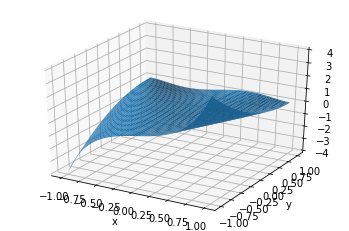

Regression weights : [-0.00464736  0.74423948 -0.          0.39366551 -0.          0.02476349
 -0.          0.00968563 -1.15600968  0.         -0.58354303  0.
 -0.          0.         -0.          0.44318502 -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.
  0.        ]


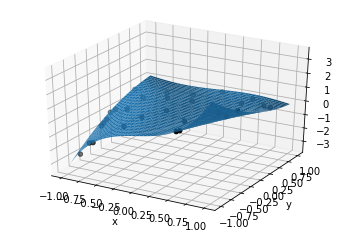

[-0.00464736  0.74423948 -0.          0.39366551 -0.          0.02476349
 -0.          0.00968563 -1.15600968  0.         -0.58354303  0.
 -0.          0.         -0.          0.44318502 -0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.
  0.        ]


In [ ]:
def MonteCarloMetaModel2D():
    Order = 6                 # Polynomial order (full tensorial functional space for the 2D case)
    NbQPs = 30                # Number of Model Evaluations (random sequence)
    TypeRegularisation = 2    # 1: Ridge, 2: Lasso, 3: Bayesian
    RegulCoeff = 1.0e-2       # regularisaiton coeff (for ridge or lasso only)
    np.random.seed( 11 )

    print(' -------------------------------------------------------')
    print(' ---------- Fit regularised regression model -----------')
    print(' -------------------------------------------------------')

    M = SimpleModel2D()
    M.plot([-1,1],[-1,1],[100,100])
    plt.show()
    
    MM = LegendreMM2D()
    MM.FullModel = M
    MM.order = Order
    MM.TypeQuadrature = 'MC'
    MM.TypeRegularisation=TypeRegularisation
    MM.RegulCoeff = RegulCoeff 
    MM.NbQPs = NbQPs
    MM.BuildQuadrature()
    MM.Fit()
    MM.plot([-1,1],[-1,1],[40,40])
    plt.show()
    
    print(MM.Weights)


MonteCarloMetaModel2D()

NameError: ignored



---


**Exercise 3: Nonparametric bayesian modelling: Gaussian Process Regression**

1. Implement an exponential Kernel: modify the Covariance matrix and the cross-covariance vector
2. Implement the automatic choice of the covariance length scale by maximising the data likelihood (at the moment, the amplitude of the Kernel is optimised
3. Optimise both the amplitude and length-scale parameters

Note: look for comments "... is to be updated" in the code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt    
from scipy.optimize import fmin_bfgs, fmin, fminbound

class SimpleModel1D:
    
    def eval(self,x) :
        f = np.sin(3.0*x-2.25) + abs(x) + x
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,c='black',)

In [ ]:
class GPRegressionMM1D:
    
    def __init__(self):
         
        self.FullModel = None       # Full model
        self.Centers = None         # list of coordinates of data points ("x")
        self.Vals = None            # list of function values at data points ("y")
        self.NbRBFs = 10            # Number of data points
        self.TypeQuadrature = 'MC'  # Type of automatised sempling 'MC' (random) or 'Uniform' (deterministic)
        self.l = 1.0                # length scale of exponential covariance Kernel
        self.Covariance = None      # data covariance matrix
        self.A = 1.0                # amplitude of exponential covariance Kernel
        self.sigma = 1.e-8          # amplitude of white noise Kernel
    
    def BuildQuadrature(self):

        if self.TypeQuadrature == 'MC':
            self.Centers = 2.0 * np.random.rand(self.NbRBFs,1) - 1.0
        elif self.TypeQuadrature == 'Uniform':
            self.Centers = np.linspace(-1,1,self.NbRBFs)
        else:
            print('nod coded')
    
    def Fit(self):

        self.Vals = np.zeros((self.NbRBFs,1))
        for i in range(self.NbRBFs):
            self.Vals[i] = self.FullModel.eval(self.Centers[i])
        self.Covariance = np.zeros((len(self.Centers),len(self.Centers)))

        # Covariance matrix is to be updated
        # self.Vals is a vector containing the model outputs
        # self.Centers is a vector containing the model inputs
        # self.l is the length-scale of the Kernel
        # self.A is the amplitude Kernel
        # you should not need anything else
        self.Covariance = self.A * np.identity(len(self.Centers)) 

        self.Covariance = self.Covariance + self.sigma * np.identity(len(self.Centers))     
        #print('np.linalg.cond(self.Covariance) ', np.linalg.cond(self.Covariance))
    
    def eval(self,x) :

        CrossCo = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            # Cross-covariance vector is to be updated (covariance between all available data and 1 new prediction at input x)
            CrossCo[i] = 0.     

        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        f = np.dot(np.transpose(CrossCo),Tmp)
        
        Tmp = np.linalg.solve(self.Covariance,CrossCo)
        Covf = self.A - np.dot(np.transpose(CrossCo),Tmp)
        return f, Covf
    
    def LogLikelihood(self) :
        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        # https://blogs.sas.com/content/iml/2012/10/31/compute-the-log-determinant-of-a-matrix.html
        LogLike = - 0.5 * np.dot(np.transpose(self.Vals),Tmp) - 0.5 * self.Covariance.shape[0] * np.log(2*np.pi) #(eq. 2.30 rasmussen book Gaussian Process for Machine Learning)
        #logdet = np.log(np.linalg.det(self.Covariance))
        sign, logdet = np.linalg.slogdet(self.Covariance)
        LogLike = LogLike - 0.5*logdet
        return LogLike

    def Objectif(self,mu):
        self.A = np.exp(mu[0]) 
        self.Fit() # recompute data covariance
        return -1.0*self.LogLikelihood()

    def Optimise(self):
        muInit = [0.] # log of the initial value for self.A
        InitVal = self.Objectif(muInit)
        mu_opt = fmin_bfgs( self.Objectif , muInit , gtol=1e-3)
        #mu_opt = fmin( self.Objectif , muInit )  
        print('optimal parameter:', mu_opt, ' f value at optimal :', self.Objectif(mu_opt), 'Init : ',  muInit ,  ' f value at init :', InitVal )
    
    def plot(self,xLim,NPoint):

        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        # plot posterior mean and 95% credible region
        yPlot = np.copy(xPlot)
        yPlotP = np.copy(xPlot)
        yPlotM= np.copy(xPlot)
        for i in range(len(xPlot)):
            f, Covf = self.eval(xPlot[i])
            yPlot[i] = f
            yPlotP[i] = f + 1.96 * Covf
            yPlotM[i] = f - 1.96 * Covf
        plt.plot(xPlot,yPlot,'blue')
        plt.plot(xPlot,yPlotP,'r')
        plt.plot(xPlot,yPlotM,'g')
        plt.scatter(self.Centers,self.Vals, marker='o', c='black')

 ----------------------------------
 ---------- Exercise GP -----------
 ----------------------------------
 ---------------------------------------
 ---------- Gaussian process -----------
 ---------------------------------------


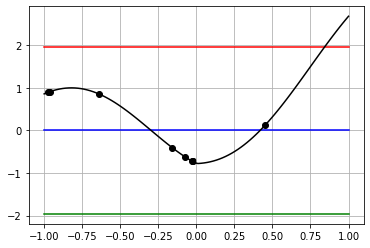

 ------------------------------------------------------
 ---------- Optimisation of data likelihood -----------
 ------------------------------------------------------
log likelihood [[-9.34029255]]
Optimization terminated successfully.
         Current function value: 8.556425
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6
optimal parameter: [-0.69876242]  f value at optimal : [[8.55642493]] Init :  [0.0]  f value at init : [[9.34029255]]


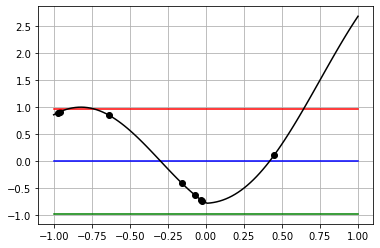

In [ ]:
def GaussianProcessMetaModel1D():

    print(' ----------------------------------')
    print(' ---------- Exercise GP -----------')
    print(' ----------------------------------')
    #print(' 1. Implement an exponential Kernel: modify the Covariance matrix and the cross-covariance vector')
    #print(' 2. Implement the automatic choice of the covariance length scale by maximising the data likelihood (at the moment, the amplitude of the Kernel is optimised')
    #print(' 3. Optimise both the amplitude and length-scale parameters')

    NSampling = 8
    SmoothingLength = 0.2

    #TypeTypeQuadrature = 'Uniform'
    TypeTypeQuadrature = 'MC'

    RidgeCoeff = 1e-10
    np.random.seed(11)

    print(' ---------------------------------------')
    print(' ---------- Gaussian process -----------')
    print(' ---------------------------------------')

    plt.figure()
    M = SimpleModel1D()
    #MM = KernelRegressionMM1D() 
    MM = GPRegressionMM1D() 
    MM.FullModel = M
    MM.TypeQuadrature = TypeTypeQuadrature
    MM.NbRBFs = NSampling # Number of uniformly, randomly distributed radial basis functions
    MM.l = SmoothingLength # length scale of Kernel smoother
    MM.RidgeCoeff = RidgeCoeff
    MM.BuildQuadrature()
    MM.Fit()
    MM.plot([-1,1],100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

    print(' ------------------------------------------------------')
    print(' ---------- Optimisation of data likelihood -----------')
    print(' ------------------------------------------------------')

    print('log likelihood',MM.LogLikelihood())
    MM.Optimise()
    MM.plot([-1,1],100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

GaussianProcessMetaModel1D() 

---


**Exercise 4: Bayesian optimisation**

Suggest and implement a Greedy algorithm to iteratively add points to the data set based on (a) minimising uncertainty (b) finding the location of the minimum of the function

Note: look for comment "change this" in the code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt    

class SimpleModel1D:
    
    def eval(self,x) :
        f = np.sin(3.0*x-2.25) + abs(x) + x
        return f
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        yPlot = self.eval(xPlot)
        plt.plot(xPlot,yPlot,c='black',)

In [ ]:
class GPRegressionMM1D:
    
    def __init__(self):
         
        self.FullModel = None       # Full model
        self.Centers = None         # list of coordinates of data points ("x")
        self.Vals = None            # list of function values at data points ("y")
        self.NbRBFs = 10            # Number of data points
        self.TypeQuadrature = 'MC'  # Type of automatised sempling 'MC' (random) or 'Uniform' (deterministic)
        self.l = 1.0                # length scale of exponential covariance Kernel
        self.Covariance = None      # data covariance matrix
        self.A = 1.0                # amplitude of exponential covariance Kernel
        self.sigma = 1.e-8          # amplitude of white noise Kernel
        self.ParameterSpace = [-1,1]
    
    def BuildQuadrature(self):
        if self.TypeQuadrature == 'MC':
            self.Centers = (self.ParameterSpace[1] - self.ParameterSpace[0]) * np.random.rand(self.NbRBFs,1) + self.ParameterSpace[0]
        elif self.TypeQuadrature == 'Uniform':
            self.Centers = np.linspace(-1,1,self.NbRBFs)
        else:
            print('nod coded')
    
    def Fit(self):
        self.Vals = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            self.Vals[i] = self.FullModel.eval(self.Centers[i])
        self.Covariance = np.zeros((len(self.Centers),len(self.Centers)))
        for i in range(len(self.Centers)):
            for j in range(len(self.Centers)):
                distance = self.Centers[i] - self.Centers[j]
                self.Covariance[i,j] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )

        self.Covariance = self.Covariance + self.sigma * np.identity(len(self.Centers))   
        print('np.linalg.cond(self.Covariance) ', np.linalg.cond(self.Covariance))
    
    def eval(self,x) :
        CrossCo = np.zeros((len(self.Centers),1))
        for i in range(len(self.Centers)):
            distance = self.Centers[i] - x
            CrossCo[i] = self.A * np.exp( -1.0/(2*self.l**2) * distance**2 )
        Tmp = np.linalg.solve(self.Covariance,self.Vals)
        f = np.dot(np.transpose(CrossCo),Tmp)
        
        Tmp = np.linalg.solve(self.Covariance,CrossCo)
        Covf = self.A - np.dot(np.transpose(CrossCo),Tmp)
        return f, Covf

    def OptimNewPoint(self) :
        NewPoint = 2.0 * np.random.rand(1,1) - 1.0 # change this !!!
        print('NewPoint',NewPoint)
        self.Centers = np.append(self.Centers,NewPoint)

    def ActiveLearning(self,NActiveLearning) :
        for i in range(NActiveLearning):
            self.OptimNewPoint()
            self.Fit()
            self.plot(self.ParameterSpace,100)
            plt.grid()
            plt.show()
    
    def plot(self,xLim,NPoint):
        xPlot = np.linspace(xLim[0],xLim[1], NPoint)
        # plot posterior mean and 95% credible region
        yPlot = np.copy(xPlot)
        yPlotP = np.copy(xPlot)
        yPlotM= np.copy(xPlot)
        for i in range(len(xPlot)):
            f, Covf = self.eval(xPlot[i])
            yPlot[i] = f
            yPlotP[i] = f + 1.96 * Covf
            yPlotM[i] = f - 1.96 * Covf
        plt.plot(xPlot,yPlot,'blue')
        plt.plot(xPlot,yPlotP,'r')
        plt.plot(xPlot,yPlotM,'g')
        plt.scatter(self.Centers,self.Vals, marker='o', c='black')

 ----------------------------------
 ---------- Exercise GP -----------
 ----------------------------------
 1. Implement an exponential Kernel Covariance matrix 
 2. Propose a Greedy algorithm to iteratively add points to the data set
 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood
 ---------------------------------------
 ---------- Gaussian process -----------
 ---------------------------------------
np.linalg.cond(self.Covariance)  1.7591197448315234


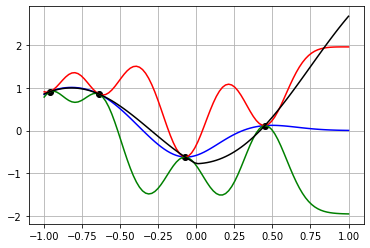

 --------------------------------------
 ---------- Active Learning -----------
 --------------------------------------
NewPoint [[-0.15959279]]
np.linalg.cond(self.Covariance)  21.969153195353215


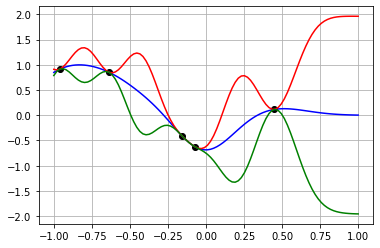

NewPoint [[-0.0291458]]
np.linalg.cond(self.Covariance)  1035.6980171672278


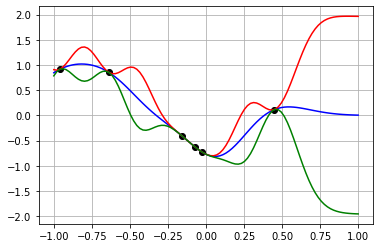

NewPoint [[-0.97443837]]
np.linalg.cond(self.Covariance)  1575.7411607403237


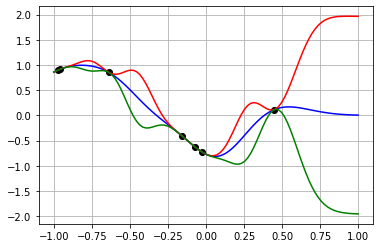

NewPoint [[-0.02525679]]
np.linalg.cond(self.Covariance)  6027287.568835261


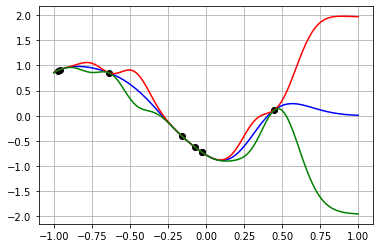

In [ ]:
def GaussianProcessMetaModel1D():

    print(' ----------------------------------')
    print(' ---------- Exercise GP -----------')
    print(' ----------------------------------')
    print(' 1. Implement an exponential Kernel Covariance matrix ')
    print(' 2. Propose a Greedy algorithm to iteratively add points to the data set')
    print(' 3. Implement the automatic choice of the covariance length scale by maximising the data likelihood')

    NSampling = 4
    SmoothingLength = 0.2

    #TypeTypeQuadrature = 'Uniform'
    TypeTypeQuadrature = 'MC'

    RidgeCoeff = 1e-10
    np.random.seed(11)

    print(' ---------------------------------------')
    print(' ---------- Gaussian process -----------')
    print(' ---------------------------------------')

    plt.figure()
    M = SimpleModel1D()
    #MM = KernelRegressionMM1D() 
    MM = GPRegressionMM1D() 
    MM.FullModel = M
    MM.TypeQuadrature = TypeTypeQuadrature
    MM.ParameterSpace = [-1,1]
    MM.NbRBFs = NSampling # Number of uniformly, randomly distributed radial basis functions
    MM.l = SmoothingLength # length scale of Kernel smoother
    MM.RidgeCoeff = RidgeCoeff
    MM.BuildQuadrature()
    MM.Fit()
    MM.plot(MM.ParameterSpace,100)
    M.plot([-1,1],100)
    plt.grid()
    plt.show()

    print(' --------------------------------------')
    print(' ---------- Active Learning -----------')
    print(' --------------------------------------')

    NActiveLearning = 4
    MM.ActiveLearning(NActiveLearning)

GaussianProcessMetaModel1D() 